In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar


In [4]:
def square_loss(predictions, y):
    N = len(y)
    loss = np.mean((predictions - y) ** 2) / 2
    return loss

def logistic_loss_and_grad(w, X, y):
    # Convert y to a numpy array and reshape
    y = np.array(y).reshape(-1, 1)
    z = np.dot(X, w)
    predictions = 1 / (1 + np.exp(-z))
    # predictions = np.where(predictions >= 0.5, 1, 0)
    # loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    loss = square_loss(predictions, y)
    grad = np.dot(X.T, (predictions - y)) / len(y)
    print("1 "+str(loss))

    return loss, grad.flatten()


def adaptive_step_size(w, grad, loss_func, X, y):
    # Define the objective function for the step size optimization
    def objective(step):
        # Apply the step size to the gradient direction
        w_new = w - step * grad
        loss, _ = loss_func(w_new, X, y)
        return loss
    
    # Use minimize_scalar to find the optimal step size
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    return result.x

def update_weights(X, y, w, method='random', max_iter=1000, tol=1e-5):
    """
    Update weights using Random, Cyclic, or Greedy Coordinate Descent with adaptive step size.
    """
    n_samples, n_features = X.shape
    loss_history = []

    for it in range(max_iter):
        loss, grad = logistic_loss_and_grad(w, X, y)
        # print("2 "+method +str(it) + " " +str(loss))
        loss_history.append(loss)
        # print(method, loss)

        if method == 'random':
            coord = np.random.randint(0, n_features)
        elif method == 'cyclic':
            coord = it % n_features
        elif method == 'greedy':
            coord = np.argmax(np.abs(grad))

        # step_size = adaptive_step_size(w[coord], grad[coord], logistic_loss_and_grad, X, y)
        # w[coord] -= step_size * grad[coord]

        # new_loss, _ = logistic_loss_and_grad(w, X, y)
        # if np.abs(new_loss - loss) < tol:
        #     break


    
        step_size = 0.01
        # Use a smaller fixed step size
        w[coord] -= step_size * grad[coord]

        new_loss, _ = logistic_loss_and_grad(w, X, y)
        if np.abs(new_loss - loss) < tol:
            break


    return w, loss_history

# def update_weights(X, y, w, method='random', max_iter=1000, tol=1e-5):
#     n_samples, n_features = X.shape
#     loss_history = []
#     param_history = []  # 记录参数变化的历史

#     for it in range(max_iter):
#         loss, grad = logistic_loss_and_grad(w, X, y)
#         loss_history.append(loss)
#         param_history.append(w.copy())  # 记录当前参数值

#         if method == 'random':
#             coord = np.random.randint(0, n_features)
#         elif method == 'cyclic':
#             coord = it % n_features
#         elif method == 'greedy':
#             coord = np.argmax(np.abs(grad))

#         step_size = adaptive_step_size(w[coord], grad[coord], logistic_loss_and_grad, X, y)
#         w[coord] -= step_size * grad[coord]

#         # 计算参数的变化
#         param_change = np.linalg.norm(w - param_history[-1], ord=2)
#         print(param_change)
#         if param_change < tol:
#             break
#     return w, loss_history


In [5]:
def random_coordinate_descent_logistic_regression(X, y, max_iter=100, tol=1e-5):
    w_initial = np.zeros(X.shape[1])  # Initialize weights
    # Call the versatile update function with 'random'
    w_updated, loss_history = update_weights(X, y, w_initial, method='random', max_iter=max_iter, tol=tol)
    return w_updated, loss_history


In [6]:
def cyclic_coordinate_descent_logistic_regression(X, y, max_iter=1000, tol=1e-5):
    w_initial = np.zeros(X.shape[1])  # Initialize weights
    # Call the versatile update function with 'cyclic'
    w_updated, loss_history = update_weights(X, y, w_initial, method='cyclic', max_iter=max_iter, tol=tol)
    return w_updated, loss_history


In [7]:
def greedy_coordinate_descent_logistic_regression(X, y, max_iter=100, tol=1e-5):
    w_initial = np.zeros(X.shape[1])  # Initialize weights
    # Call the versatile update function with 'greedy'
    w_updated, loss_history = update_weights(X, y, w_initial, method='greedy', max_iter=max_iter, tol=tol)
    return w_updated, loss_history

In [8]:
# Load the wine dataset from sklearn
data = load_wine()
wine_df = pd.DataFrame(data.data, columns=data.feature_names)
wine_df['target'] = data.target

# Filter for binary classification (class 0 and 1)
binary_wine_df = wine_df[wine_df['target'] != 2]  # Exclude class 2

# Select features and target
X = binary_wine_df.drop('target', axis=1)
y = binary_wine_df['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the shapes of the processed data
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((104, 13), (26, 13), (104,), (26,))

1 0.125
1 0.12500050417445976
1 0.125
1 0.12500050416981598
Accuracy (Random): 0.34615384615384615
Accuracy (Cyclic): 1.0


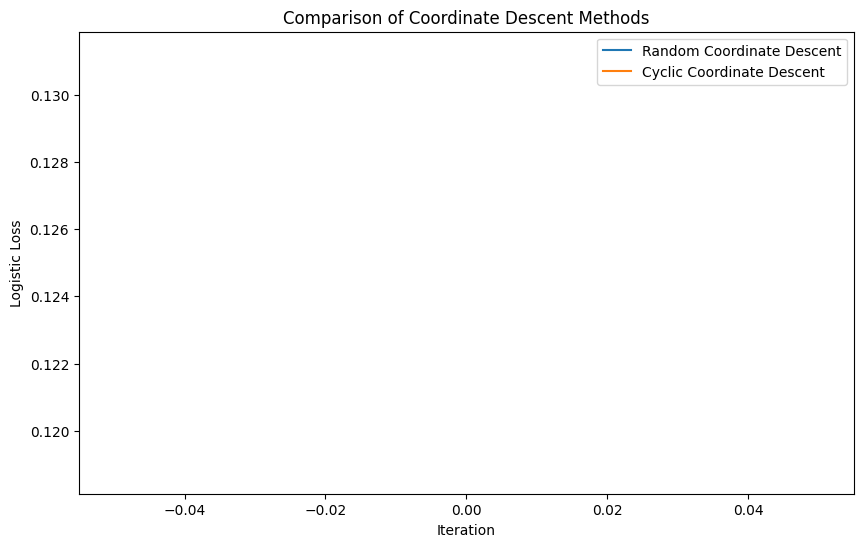

In [9]:
# Assuming X_train_scaled, y_train, X_test_scaled, y_test are already defined
from sklearn.metrics import accuracy_score

# Train models using different coordinate descent methods
w_random, loss_history_random = random_coordinate_descent_logistic_regression(X_train_scaled, y_train)
w_cyclic, loss_history_cyclic = cyclic_coordinate_descent_logistic_regression(X_train_scaled, y_train)
# w_greedy, loss_history_greedy = greedy_coordinate_descent_logistic_regression(X_train_scaled, y_train)

# Function to predict labels based on learned weights
def predict(X, w):
    proba = 1 / (1 + np.exp(-np.dot(X, w)))
    return (proba >= 0.5).astype(int)

# Evaluate each model on the test set
accuracy_random = accuracy_score(y_test, predict(X_test_scaled, w_random))
accuracy_cyclic = accuracy_score(y_test, predict(X_test_scaled, w_cyclic))
# accuracy_greedy = accuracy_score(y_test, predict(X_test_scaled, w_greedy))

# Print accuracies
print(f"Accuracy (Random): {accuracy_random}")
print(f"Accuracy (Cyclic): {accuracy_cyclic}")
# print(f"Accuracy (Greedy): {accuracy_greedy}")

# Plot loss history for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history_random, label='Random Coordinate Descent')
plt.plot(loss_history_cyclic, label='Cyclic Coordinate Descent')
# plt.plot(loss_history_greedy, label='Greedy Coordinate Descent')
plt.xlabel('Iteration')
plt.ylabel('Logistic Loss')
plt.title('Comparison of Coordinate Descent Methods')
plt.legend()
plt.show()


In [ ]:
# Initial weights
w_initial = np.zeros(X_train_scaled.shape[1])

# Update weights using Random Coordinate Descent
w_updated_random, loss_history_random = update_weights(X_train_scaled, y_train, w_initial.copy(), method='random')

In [5]:
# Logistic Loss and Gradient Calculation
def logistic_loss_and_grad(w, X, y):
    w = w.reshape(-1, 1)
    y = y.reshape(-1, 1)
    z = np.dot(X, w)
    predictions = 1 / (1 + np.exp(-z))
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    grad = np.dot(X.T, (predictions - y)) / len(y)
    return loss, grad.flatten()

In [6]:
# Greedy Coordinate Descent
def greedy_coordinate_descent_logistic_regression(X, y, max_iter=1000, tol=1e-4):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    loss_history = []
    for it in range(max_iter):
        loss, grad = logistic_loss_and_grad(w, X, y)
        loss_history.append(loss)
        coord = np.argmax(np.abs(grad))
        w[coord] -= (1 / (it + 1)) * grad[coord]
        new_loss, _ = logistic_loss_and_grad(w, X, y)
        if abs(new_loss - loss) < tol:
            return w, loss_history
        loss = new_loss
    return w, loss_history

In [22]:
X.shape

(130, 13)

In [19]:
# Random Coordinate Descent
def random_coordinate_descent_logistic_regression(X, y, max_iter=1000, tol=1e-5):
    n_samples, n_features = X.shape
    w = np.random.rand(n_features)
    loss_history = []
    for it in range(max_iter):
        loss, _ = logistic_loss_and_grad(w, X, y)
        loss_history.append(loss)
        coord = np.random.randint(0, n_features)
        _, grad = logistic_loss_and_grad(w, X, y)
        w[coord] -= (1 / (it + 1)) * grad[coord]
        new_loss, _ = logistic_loss_and_grad(w, X, y)
        print(new_loss)
        if new_loss > loss:
            return w, loss_history
        loss = new_loss
    return w, loss_history

In [12]:
# Cyclic Coordinate Descent
def cyclic_coordinate_descent_logistic_regression(X, y, max_iter=100, tol=1e-4):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    loss_history = []
    for it in range(max_iter):
        loss, _ = logistic_loss_and_grad(w, X, y)
        loss_history.append(loss)
        for coord in range(n_features):
            _, grad = logistic_loss_and_grad(w, X, y)
            w[coord] -= (1 / (it + 1)) * grad[coord]
            new_loss, _ = logistic_loss_and_grad(w, X, y)
            if abs(new_loss - loss) < tol:
                return w, loss_history
            loss = new_loss
    return w, loss_history

In [13]:
# Example usage with the Wine dataset
data = load_wine()
wine_df = pd.DataFrame(data.data, columns=data.feature_names)
wine_df['target'] = data.target
binary_wine_df = wine_df[wine_df['target'] < 2]
X = binary_wine_df.drop('target', axis=1).values
y = binary_wine_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Execute Random Coordinate Descent
w_opt_random, loss_history_random = random_coordinate_descent_logistic_regression(X_train_scaled, y_train, max_iter=100)

# Execute Cyclic Coordinate Descent
w_opt_cyclic, loss_history_cyclic = cyclic_coordinate_descent_logistic_regression(X_train_scaled, y_train, max_iter=100)

# Execute Greedy Coordinate Descent
w_opt_greedy, loss_history_greedy = greedy_coordinate_descent_logistic_regression(X_train_scaled, y_train, max_iter=100)

# Collecting the final loss from each method for comparison
final_loss_random = loss_history_random[-1] if loss_history_random else None
final_loss_cyclic = loss_history_cyclic[-1] if loss_history_cyclic else None
final_loss_greedy = loss_history_greedy[-1] if loss_history_greedy else None

final_loss_random, final_loss_cyclic, final_loss_greedy


2.090769038290229
2.0780847196838272
1.9683210925365044
1.9330692507782539
1.9061133382511741
1.873340979080499
1.8214492927987973
1.819850419610023
1.8060378777365302
1.7944864818459185
1.7923336735188709
1.7822558591439965
1.769620069349808
1.7565463214386599
1.7538719825596603
1.742644730524788
1.7226066766220716
1.7213166140428293
1.7127609873487706
1.7121175420028178
1.7102974278900414
1.7097196451791967
1.6951611024114421
1.6837739484697396
1.6794787054795248
1.6651350779249736
1.6558191659427897
1.6551682020451346
1.6515623093005456
1.650791047174219
1.6503794351054686
1.645360466465346
1.644292041483293
1.63958679934798
1.6385836792046269
1.6296405816754105
1.626703912068361
1.6202261072128141
1.6159698699677787
1.6151248189148093
1.6132209953599894
1.6074363295418985
1.605090811389462
1.6014796606339816
1.5961223332898637
1.5905233882314929
1.5829286538522578
1.5807408501711426
1.5804234536806787
1.579963612832041
1.5797131206681292
1.5794688436317526
1.5790353835123485
1.5776

(1.4892315982749076, 0.6931471805599453, 0.3003633250857122)